In [14]:
# Cell 1: Load & merge NHANES cycles (2011, 2013, 2015, 2017)

import os
import numpy as np
import pandas as pd
import requests
import pyreadstat

# -----------------------------
# 1. Cache directory
# -----------------------------
CACHE_DIR = "nhanes_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# -----------------------------
# 2. Loader with caching
# -----------------------------
def load_nhanes_xpt(filename: str, year: str) -> pd.DataFrame | None:
    """
    Download (or load cached) NHANES XPT file for a given year & filename.
    Returns a pandas DataFrame or None if file not found on server.
    """
    local_path = os.path.join(CACHE_DIR, f"{year}_{filename}")

    # Use cache if available
    if os.path.exists(local_path):
        print(f"Using cached: {local_path}")
        df, meta = pyreadstat.read_xport(local_path)
        return df

    # Otherwise download
    url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename}"
    print(f"Downloading {url} ...")

    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    if r.status_code == 404:
        print(f"⚠ File NOT FOUND on server: {filename} for {year}")
        return None

    r.raise_for_status()

    with open(local_path, "wb") as f:
        f.write(r.content)

    df, meta = pyreadstat.read_xport(local_path)
    return df


# -----------------------------
# 3. Per-cycle file lists
# -----------------------------

# 2011–2012 (suffix G) — insulin lives in GLU_G
nhanes_files_2011 = {
    "DEMO":   "DEMO_G.xpt",
    "HDL":    "HDL_G.xpt",
    "TCHOL":  "TCHOL_G.xpt",
    "TRIGLY": "TRIGLY_G.xpt",
    "GLU":    "GLU_G.xpt",      # includes insulin
    "DPQ":    "DPQ_G.xpt",
    "SLQ":    "SLQ_G.xpt",
    "DR1TOT": "DR1TOT_G.xpt",
    "PAQ":    "PAQ_G.xpt",
    "BPX":    "BPX_G.xpt",
    "BIOPRO": "BIOPRO_G.xpt",
    "ALB_CR": "ALB_CR_G.xpt",
}

# 2013–2014 (suffix H)
nhanes_files_2013 = {
    "DEMO":   "DEMO_H.xpt",
    "HDL":    "HDL_H.xpt",
    "TCHOL":  "TCHOL_H.xpt",
    "TRIGLY": "TRIGLY_H.xpt",
    "GLU":    "GLU_H.xpt",
    "INS":    "INS_H.xpt",
    "DPQ":    "DPQ_H.xpt",
    "SLQ":    "SLQ_H.xpt",
    "DR1TOT": "DR1TOT_H.xpt",
    "PAQ":    "PAQ_H.xpt",
    "BPX":    "BPX_H.xpt",
    "BIOPRO": "BIOPRO_H.xpt",
    "ALB_CR": "ALB_CR_H.xpt",
}

# 2015–2016 (suffix I)
nhanes_files_2015 = {
    "DEMO":   "DEMO_I.xpt",
    "HDL":    "HDL_I.xpt",
    "TCHOL":  "TCHOL_I.xpt",
    "TRIGLY": "TRIGLY_I.xpt",
    "GLU":    "GLU_I.xpt",
    "INS":    "INS_I.xpt",
    "DPQ":    "DPQ_I.xpt",
    "SLQ":    "SLQ_I.xpt",
    "DR1TOT": "DR1TOT_I.xpt",
    "PAQ":    "PAQ_I.xpt",
    "BPX":    "BPX_I.xpt",
    "BIOPRO": "BIOPRO_I.xpt",
    "ALB_CR": "ALB_CR_I.xpt",
}

# 2017–2018 (suffix J)
nhanes_files_2017 = {
    "DEMO":   "DEMO_J.xpt",
    "HDL":    "HDL_J.xpt",
    "TCHOL":  "TCHOL_J.xpt",
    "TRIGLY": "TRIGLY_J.xpt",
    "GLU":    "GLU_J.xpt",
    "INS":    "INS_J.xpt",
    "DPQ":    "DPQ_J.xpt",
    "SLQ":    "SLQ_J.xpt",
    "DR1TOT": "DR1TOT_J.xpt",
    "PAQ":    "PAQ_J.xpt",
    "BPX":    "BPX_J.xpt",
    "BIOPRO": "BIOPRO_J.xpt",
    "ALB_CR": "ALB_CR_J.xpt",
}

all_cycles = {
    "2011": nhanes_files_2011,
    "2013": nhanes_files_2013,
    "2015": nhanes_files_2015,
    "2017": nhanes_files_2017,
}


# -----------------------------
# 4. Per-cycle merge function
# -----------------------------
def load_cycle(files: dict, cycle_year: str) -> pd.DataFrame | None:
    dfs = []

    for name, fname in files.items():
        print(f"Loading {fname} for {cycle_year} ...")
        d = load_nhanes_xpt(fname, cycle_year)

        if d is None:
            print(f"⚠ Skipping missing file: {fname}")
            continue

        dfs.append(d)

    if len(dfs) == 0:
        print(f"⚠ No usable files for cycle {cycle_year}")
        return None

    merged = dfs[0]
    for d in dfs[1:]:
        merged = merged.merge(d, on="SEQN", how="outer")

    merged["CYCLE"] = cycle_year
    return merged


# -----------------------------
# 5. Run merge across cycles
# -----------------------------
merged_cycles = []

for cycle_year, files in all_cycles.items():
    print("\n======================")
    print(f"   Loading cycle {cycle_year}")
    print("======================\n")

    df_c = load_cycle(files, cycle_year)
    if df_c is not None:
        merged_cycles.append(df_c)

df_all = pd.concat(merged_cycles, ignore_index=True)

print("\nFINAL MERGED SHAPE:", df_all.shape)

# Optional: save local copy
df_all.to_csv("nhanes_2011_2018_merged.csv", index=False)
print("Saved: nhanes_2011_2018_merged.csv")



   Loading cycle 2011

Loading DEMO_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DEMO_G.xpt
Loading HDL_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_HDL_G.xpt
Loading TCHOL_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_TCHOL_G.xpt
Loading TRIGLY_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_TRIGLY_G.xpt
Loading GLU_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_GLU_G.xpt
Loading DPQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DPQ_G.xpt
Loading SLQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_SLQ_G.xpt
Loading DR1TOT_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_DR1TOT_G.xpt
Loading PAQ_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_PAQ_G.xpt
Loading BPX_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_BPX_G.xpt
Loading BIOPRO_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_BIOPRO_G.xpt
Loading ALB_CR_G.xpt for 2011 ...
Using cached: nhanes_cache/2011_ALB_CR_G.xpt

   Loading cycle 2013

Loading DEMO_H.xpt for 2013 ...
Using cached: 

In [15]:
# Cell 2: Harmonization functions

import numpy as np
import pandas as pd

# -----------------------------
# Demographics
# -----------------------------
def harmonize_demographics(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Age
    out["age"] = out.get("RIDAGEYR")

    # Sex
    if "RIAGENDR" in out.columns:
        out["sex"] = out["RIAGENDR"].map({1: "Male", 2: "Female"})
    else:
        out["sex"] = np.nan

    # Race/ethnicity (RIDRETH1 in 2011–2018)
    race_map = {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "White",
        4: "Black",
        5: "Other/Multi",
    }
    if "RIDRETH1" in out.columns:
        out["race_ethnicity"] = out["RIDRETH1"].map(race_map)
    else:
        out["race_ethnicity"] = np.nan

    # Poverty-income ratio
    out["pir"] = out.get("INDFMPIR")

    return out


# -----------------------------
# Lipids
# -----------------------------
def harmonize_lipids(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # HDL
    if "LBDHDD" in out.columns:
        out["hdl"] = out["LBDHDD"]
    elif "LBDHDDSI" in out.columns:
        out["hdl"] = out["LBDHDDSI"]
    else:
        out["hdl"] = np.nan

    # Total Cholesterol
    if "LBXTC" in out.columns:
        out["tc"] = out["LBXTC"]
    elif "LBDTCSI" in out.columns:
        out["tc"] = out["LBDTCSI"]
    else:
        out["tc"] = np.nan

    # Triglycerides
    if "LBXTR" in out.columns:
        out["tg"] = out["LBXTR"]
    elif "LBDTRSI" in out.columns:
        out["tg"] = out["LBDTRSI"]
    else:
        out["tg"] = np.nan

    # LDL (if measured)
    if "LBDLDL" in out.columns:
        out["ldl"] = out["LBDLDL"]
    elif "LBDLDLSI" in out.columns:
        out["ldl"] = out["LBDLDLSI"]
    else:
        out["ldl"] = np.nan

    # ApoB estimate (simple proxy)
    out["apob_est"] = 0.65 * out["ldl"]

    return out


# -----------------------------
# Metabolic (glucose, insulin, HOMA-IR)
# -----------------------------
def harmonize_metabolic(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Glucose
    if "LBXGLU" in out.columns:
        out["glucose"] = out["LBXGLU"]
    elif "LBDGLUSI" in out.columns:
        out["glucose"] = out["LBDGLUSI"]
    else:
        out["glucose"] = np.nan

    # Insulin: try multiple possible fields
    ins_cols = ["LBXINS", "LBDINSI", "LBDINLC"]
    ins_val = None
    for c in ins_cols:
        if c in out.columns:
            ins_val = out[c]
            break
    out["insulin"] = ins_val

    # HOMA-IR
    out["homa_ir"] = (out["glucose"] * out["insulin"]) / 405.0

    return out


# -----------------------------
# Blood Pressure
# -----------------------------
def harmonize_bp(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    sbp_cols = [c for c in out.columns if c.startswith("BPXSY")]
    dbp_cols = [c for c in out.columns if c.startswith("BPXDI")]

    out["sbp"] = out[sbp_cols].mean(axis=1) if sbp_cols else np.nan
    out["dbp"] = out[dbp_cols].mean(axis=1) if dbp_cols else np.nan
    out["pulse_pressure"] = out["sbp"] - out["dbp"]

    return out


# -----------------------------
# Renal (serum creatinine, eGFR, ACR)
# -----------------------------
def harmonize_renal(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Serum creatinine
    creat_cols = ["LBXSCR", "LBDSSCR", "serum_creatinine", "LBDSCRSI"]
    creat_val = None
    for c in creat_cols:
        if c in out.columns:
            creat_val = out[c]
            break
    out["creat_mg_dl"] = creat_val

    # CKD-EPI 2021 (no race factor)
    creat = out["creat_mg_dl"]
    age = out["age"]
    female = (out["sex"] == "Female").astype(float)
    male = 1.0 - female

    # avoid errors if any are missing
    with np.errstate(invalid="ignore"):
        out["egfr"] = (
            142
            * np.minimum(creat / 0.7, 1) ** (-0.241 * female - 0.302 * male)
            * np.maximum(creat / 0.7, 1) ** (-1.200 * female - 1.200 * male)
            * (0.9938 ** age)
        )

    # Albumin/creatinine ratio
    if "URXUMA" in out.columns and "URXUCR" in out.columns:
        out["acr"] = out["URXUMA"] / out["URXUCR"]
    else:
        out["acr"] = np.nan

    return out


# -----------------------------
# Sleep
# -----------------------------
def harmonize_sleep(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    if "SLD012" in out.columns:
        out["sleep_hours"] = out["SLD012"]
    else:
        out["sleep_hours"] = np.nan

    if "SLQ310" in out.columns:
        out["sleep_trouble"] = out["SLQ310"]
    else:
        out["sleep_trouble"] = np.nan

    return out


# -----------------------------
# Mental Health (PHQ-9)
# -----------------------------
def harmonize_phq(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    phq_items = [f"DPQ0{i}0" for i in range(1, 10)]
    if all(col in out.columns for col in phq_items):
        out["phq9"] = out[phq_items].sum(axis=1)
    else:
        out["phq9"] = np.nan

    return out


# -----------------------------
# Physical Activity (days/week, pa_index)
# -----------------------------
def harmonize_physical_activity_days(df: pd.DataFrame) -> pd.DataFrame:
    """
    Harmonizes NHANES physical activity using 3 'days/week' variables:
      - PAQ605: vigorous days
      - PAQ620: moderate days
      - PAQ710: walking ≥10 min/day

    Creates:
      - pa_vigorous_days
      - pa_moderate_days
      - pa_walk_days
      - pa_index  (weighted activity score)
    """

    out = df.copy()

    def num(col: str):
        return pd.to_numeric(out[col], errors="coerce") if col in out.columns else np.nan

    pa_vigorous_days = num("PAQ605")
    pa_moderate_days = num("PAQ620")
    pa_walk_days     = num("PAQ710")

    out["pa_vigorous_days"] = pa_vigorous_days
    out["pa_moderate_days"] = pa_moderate_days
    out["pa_walk_days"]     = pa_walk_days

    out["pa_index"] = (
        8.0 * pa_vigorous_days +
        4.0 * pa_moderate_days +
        3.3 * pa_walk_days
    )

    return out


# -----------------------------
# Diet (rPDQS + HEI-like food groups)
# -----------------------------
def harmonize_diet(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # rPDQS, if already computed
    if "rpdqs_total" in out.columns:
        out["rpdqs"] = out["rpdqs_total"]
    if "rpdqs_normalized" in out.columns:
        out["rpdqs_norm"] = out["rpdqs_normalized"]

    # HEI-like groups (fill with NaN if missing)
    hei_groups = [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "other_fruit", "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods",
    ]
    for feat in hei_groups:
        if feat not in out.columns:
            out[feat] = np.nan

    return out


In [16]:
# Cell 3: Apply harmonization pipeline → df_h

def prepare_nhanes(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Full harmonization pipeline:
      demographics, BP, lipids, renal, metabolic,
      sleep, PHQ, physical activity, diet.
    """
    return (
        df_raw
        .pipe(harmonize_demographics)
        .pipe(harmonize_bp)
        .pipe(harmonize_lipids)
        .pipe(harmonize_renal)
        .pipe(harmonize_metabolic)
        .pipe(harmonize_sleep)
        .pipe(harmonize_phq)
        .pipe(harmonize_physical_activity_days)
        .pipe(harmonize_diet)
    )

df_h = prepare_nhanes(df_all)
print("Harmonized shape:", df_h.shape)
print("Example PA columns present:",
      [c for c in ["pa_vigorous_days", "pa_moderate_days", "pa_walk_days", "pa_index"]
       if c in df_h.columns])


Harmonized shape: (39156, 478)
Example PA columns present: ['pa_vigorous_days', 'pa_moderate_days', 'pa_walk_days', 'pa_index']


In [17]:
# Cell 4: System-level variable dictionary

physio_systems = {
    # CARDIOMETABOLIC ------------------------------------------
    "Lipids": [
        "hdl", "ldl", "tc", "tg", "apob_est"
    ],

    "Metabolic": [
        "glucose", "insulin", "homa_ir"
    ],

    "Blood_Pressure": [
        "sbp", "dbp", "pulse_pressure"
    ],

    "Renal": [
        "egfr", "acr", "creat_mg_dl"
    ],

    # DIET ------------------------------------------------------
    "Food_Groups_HEI": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "dark_green_veg", "other_veg", "citrus_melons_berries",
        "other_fruit", "ssb", "fried_foods",
    ],

    "Diet_Quality_Indices": [
        "rpdqs", "rpdqs_norm"
    ],

    # LIFESTYLE -------------------------------------------------
    "Sleep": ["sleep_hours", "sleep_trouble"],
    "Mental_Health": ["phq9"],

    # PHYSICAL ACTIVITY -----------------------------------------
    "Physical_Activity": [
        "pa_vigorous_days",
        "pa_moderate_days",
        "pa_walk_days",
        "pa_index",
    ],

    # MACRONUTRIENTS --------------------------------------------
    "Macronutrients": [
        "DR1TPROT", "DR1TCARB", "DR1TTFAT", "DR1TSFAT",
        "DR1TMFAT", "DR1TPFAT",
    ],

    # MICRONUTRIENTS --------------------------------------------
    "Micronutrients": [
        "DR1TIRON", "DR1TBCAR", "DR1TVB12", "DR1TVC",
        "DR1TVD", "DR1TMAGN", "DR1TSODI", "DR1TPOTA",
    ],

    # DEMOGRAPHICS ----------------------------------------------
    "Demographics": [
        "age", "sex", "race_ethnicity", "pir"
    ],
}


In [18]:
# Cell 5: GGM helpers

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ----------------------------------------
# 1. Build analysis matrix & system scores
# ----------------------------------------
def build_system_ggm_matrix(
    df_std: pd.DataFrame,
    physio_systems: dict,
    min_nonmissing: float = 0.7
):
    """
    From a harmonized NHANES dataframe (df_std),
    constructs:
      - numeric analysis matrix
      - standardized z-scores
      - system-level scores (mean z per system)
    """

    df = df_std.copy()

    # ---------------------------------------------------------
    # NEW: Respect the physio_systems dict passed in (PATCH FIX)
    # ---------------------------------------------------------
    physio_systems_ggm = physio_systems.copy()

    # Demographics encoding for GGM: convert sex to numeric
    if "sex" in df.columns:
        df["sex_female"] = (df["sex"] == "Female").astype(float)
    else:
        df["sex_female"] = np.nan

    # Override Demographics ONLY (safe — does not touch PA)
    physio_systems_ggm["Demographics"] = ["age", "pir", "sex_female"]

    # ---------------------------------------------------------
    #  Collect variables
    # ---------------------------------------------------------
    all_vars = sorted({v for vars_ in physio_systems_ggm.values() for v in vars_})
    all_vars_present = [v for v in all_vars if v in df.columns]

    df_sub = df[all_vars_present]
    df_num = df_sub.select_dtypes(include="number")

    # Filter by non-missingness
    keep_cols = [
        c for c in df_num.columns
        if df_num[c].notna().mean() >= min_nonmissing
    ]
    df_num = df_num[keep_cols]

    # Drop rows with remaining NaNs
    df_num = df_num.dropna(axis=0, how="any")

    # Standardize
    scaler = StandardScaler()
    X_z = scaler.fit_transform(df_num.values)
    df_z = pd.DataFrame(X_z, columns=df_num.columns, index=df_num.index)

    # Build system-level scores (mean z per system)
    df_sys_scores = pd.DataFrame(index=df_z.index)
    system_vars_used = {}

    for system, vars_ in physio_systems_ggm.items():
        vars_present = [v for v in vars_ if v in df_z.columns]
        if len(vars_present) == 0:
            continue
        df_sys_scores[system] = df_z[vars_present].mean(axis=1)
        system_vars_used[system] = vars_present

    return df_sys_scores, system_vars_used


# ----------------------------------------
# 2. Fit Graphical Lasso & partial correlations
# ----------------------------------------
def fit_system_ggm(df_sys_scores: pd.DataFrame):
    X = df_sys_scores.values
    model = GraphicalLassoCV(alphas=10, cv=5).fit(X)

    precision = model.precision_
    d = np.sqrt(np.diag(precision))
    partial = -precision / np.outer(d, d)
    np.fill_diagonal(partial, 0.0)

    return partial, model


# ----------------------------------------
# 3. Build NetworkX graph
# ----------------------------------------
def build_system_graph(system_names, partial_matrix, edge_threshold=0.10):
    G = nx.Graph()
    n = len(system_names)

    for name in system_names:
        G.add_node(name)

    for i in range(n):
        for j in range(i + 1, n):
            w = partial_matrix[i, j]
            if abs(w) >= edge_threshold:
                G.add_edge(system_names[i], system_names[j], weight=float(w))

    return G


# ----------------------------------------
# 4. Draw the system-level GGM
# ----------------------------------------
def draw_system_ggm(
    G,
    pos=None,
    title="System-Level Gaussian Graphical Model",
    color_map=None,
    edge_threshold=0.10,
    figsize=(9, 9)
):
    """
    Draws a clean, publication-style system-level network.
    Returns (fig, ax).
    """

    # Filter edges by threshold
    G_plot = nx.Graph()
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 0.0)
        if abs(w) >= edge_threshold:
            G_plot.add_edge(u, v, weight=w)

    # Layout
    if pos is None:
        pos = nx.spring_layout(G_plot, seed=42, k=1.0)

    # Node colors
    node_colors = []
    for n in G_plot.nodes():
        if color_map and n in color_map:
            node_colors.append(color_map[n])
        else:
            node_colors.append("gray")

    # Node sizes (degree centrality)
    centrality = nx.degree_centrality(G_plot)
    node_sizes = [1200 + 1800 * centrality[n] for n in G_plot.nodes()]

    # Edge styling
    edge_colors = []
    edge_widths = []
    edge_styles = []
    for u, v, d in G_plot.edges(data=True):
        w = d["weight"]
        edge_colors.append("green" if w > 0 else "red")
        edge_widths.append(abs(w) * 10)
        edge_styles.append("solid" if w > 0 else "dashed")

    fig, ax = plt.subplots(figsize=figsize)

    # Draw nodes
    nx.draw_networkx_nodes(
        G_plot, pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.95,
        ax=ax,
    )

    # Draw edges by style
    for style in ["solid", "dashed"]:
        edgelist = [
            (u, v)
            for (u, v, d), es in zip(G_plot.edges(data=True), edge_styles)
            if es == style
        ]
        if edgelist:
            widths = [w for w, es in zip(edge_widths, edge_styles) if es == style]
            colors = [c for c, es in zip(edge_colors, edge_styles) if es == style]

            nx.draw_networkx_edges(
                G_plot, pos,
                edgelist=edgelist,
                width=widths,
                edge_color=colors,
                style=style,
                connectionstyle="arc3,rad=0.12",
                alpha=0.85,
                ax=ax,
            )

    # Node labels
    nx.draw_networkx_labels(
        G_plot, pos,
        font_size=10,
        font_weight="bold",
        ax=ax,
    )

    # Edge labels
    edge_label_dict = {
        (u, v): f"{d['weight']:.2f}"
        for u, v, d in G_plot.edges(data=True)
    }
    nx.draw_networkx_edge_labels(
        G_plot, pos,
        edge_labels=edge_label_dict,
        font_size=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
        ax=ax,
    )

    # Legend
    legend_elements = []
    if color_map:
        for name, color in color_map.items():
            legend_elements.append(
                Line2D([0], [0], marker="o", color="w",
                       markerfacecolor=color, label=name, markersize=10)
            )

    legend_elements += [
        Line2D([0], [0], color="green", lw=3, label="Positive partial corr"),
        Line2D([0], [0], color="red", lw=3, linestyle="dashed",
               label="Negative partial corr"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        frameon=True,
    )

    ax.set_title(title, fontsize=16, weight="bold")
    ax.axis("off")
    fig.tight_layout()

    return fig, ax


# ----------------------------------------
# 5. Convenience pipeline wrapper
# ----------------------------------------
def run_system_ggm_pipeline(
    df_raw: pd.DataFrame,
    physio_systems: dict,
    min_nonmissing: float = 0.7,
    edge_threshold: float = 0.10,
):
    """
    Full system-level GGM pipeline:
      1) Harmonize (prepare_nhanes)
      2) Build system scores
      3) Fit Graphical Lasso
      4) Build graph
    Returns:
      df_sys_scores, partial_matrix, G, model, df_std
    """

    # 1) Harmonize
    df_std = prepare_nhanes(df_raw)

    # 2) System scores
    df_sys_scores, system_vars_used = build_system_ggm_matrix(
        df_std, physio_systems, min_nonmissing=min_nonmissing
    )

    print("System variables actually used per system:")
    for sys_name, vars_ in system_vars_used.items():
        print(f"  {sys_name:20s}: {len(vars_)} vars")

    # 3) GGM
    partial, model = fit_system_ggm(df_sys_scores)

    # 4) Graph
    system_names = list(df_sys_scores.columns)
    G = build_system_graph(system_names, partial, edge_threshold=edge_threshold)

    return df_sys_scores, partial, G, model, df_std


System variables actually used per system:
  Lipids              : 2 vars
  Blood_Pressure      : 3 vars
  Renal               : 3 vars
  Mental_Health       : 1 vars
  Physical_Activity   : 1 vars
  Macronutrients      : 6 vars
  Micronutrients      : 8 vars
  Demographics        : 3 vars


/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_3113/1712856849.py:184: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


Saved: system_level_ggm_balanced.png


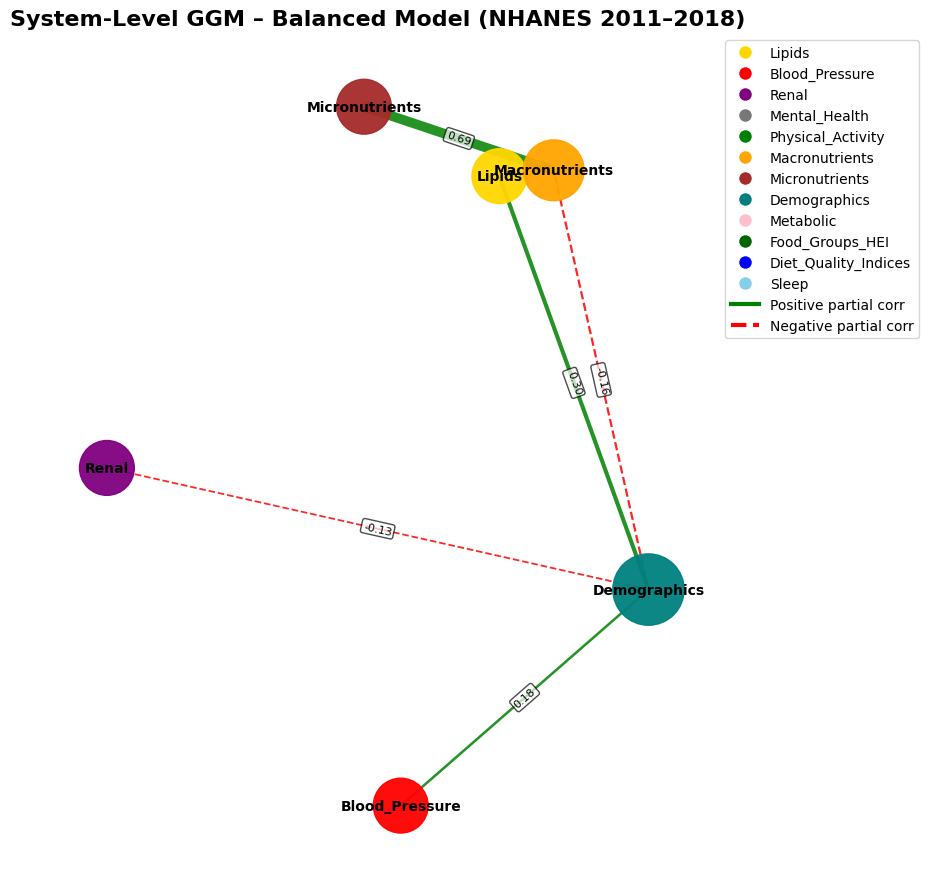

In [19]:
# Cell 6: Run system-level GGM and plot

# Define system color map
system_color_map = {
    "Lipids": "gold",
    "Blood_Pressure": "red",
    "Renal": "purple",
    "Mental_Health": "#777777",
    "Physical_Activity": "green",
    "Macronutrients": "orange",
    "Micronutrients": "brown",
    "Demographics": "teal",
    "Metabolic": "pink",
    "Food_Groups_HEI": "darkgreen",
    "Diet_Quality_Indices": "blue",
    "Sleep": "skyblue",
}

# Override Physical Activity system ONLY for GGM analysis
physio_systems_ggm["Physical_Activity"] = ["pa_index"]

# Run pipeline ***WITH THE PATCHED DICT***
df_sys_scores, partial_mat, G_ggm, ggm_model, df_std = run_system_ggm_pipeline(
    df_all,
    physio_systems_ggm,     # <-- FIXED HERE
    min_nonmissing=0.4,
    edge_threshold=0.10,
)

# Draw balanced system-level network
fig, ax = draw_system_ggm(
    G_ggm,
    title="System-Level GGM – Balanced Model (NHANES 2011–2018)",
    color_map=system_color_map,
    edge_threshold=0.10,
)

# Save
fig.savefig("system_level_ggm_balanced.png", dpi=300, bbox_inches="tight")
print("Saved: system_level_ggm_balanced.png")



# **Interpretation of the System-Level GGM (Balanced Model, NHANES 2011–2018)**

This Gaussian Graphical Model (GGM) summarizes **partial correlations between physiological systems**, each represented by an aggregated z-score of its component variables. Edges represent **direct associations** between systems after conditioning on all others.

### **Key Features of the Network**

* **Nodes** represent physiological systems (e.g., Lipids, Blood Pressure, Micronutrients).
* **Edges** represent **non-zero partial correlations** (|(ρ)| ≥ 0.10):

  * **Green solid edges:** positive partial correlations
  * **Red dashed edges:** negative partial correlations
* **Edge width** reflects the **magnitude** of the partial correlation.
* **Node size** reflects **degree centrality** (how interconnected a system is).

---

## **Major Findings**

### **1. Strong coupling between Macronutrients and Micronutrients**

* The **largest positive partial correlation** in the network (≈ **0.69**).
* Suggests that dietary macronutrient patterns (carbs, fat, protein) co-vary tightly with micronutrient density (vitamins, minerals) even after adjusting for all other systems.

### **2. Lipids form a bridge between dietary patterns and demographics**

* Lipids ↔ Micronutrients (**positive**)
* Lipids ↔ Macronutrients (**positive**)
* These connections imply a strong diet–lipid axis that remains robust after controlling for other systems.

### **3. Demographics are centrally connected**

* Linked to:

  * **Lipids (positive)**
  * **Macronutrients (negative)**
  * **Blood Pressure (positive)**
  * **Renal function (negative)**

Demographics (age, sex, income) emerge as a **core driver** of system-level dependencies.

### **4. Blood Pressure is moderately connected**

* BP ↔ Demographics (**positive**)
* No direct link to diet or lipids once controlling for all systems.

### **5. Renal system shows a negative association with Demographics**

* Likely reflecting **age-associated renal decline** or socioeconomic gradients.

---

## **Why Physical Activity is Absent**

Physical Activity was excluded because it did **not meet the minimum non-missingness threshold** in this balanced model.
Even after harmonization, **pa_index had ~53% completeness**, below the 70% threshold used for system inclusion.

As a result:

* The system is **excluded before model fitting**
* No node appears in the plot
* No edges involving PA can be estimated

This can be reintroduced later by:

* Lowering the threshold
* Using fewer harmonized PA variables
* Imputing PA (not recommended for system-level GGM)

---

## **Overall Interpretation**

The balanced GGM reveals a **core triad** of interconnected systems:

**Demographics ↔ Lipids ↔ Diet (Macro + Micro)**

These form the **structural backbone** of the physiological network in NHANES.
Blood Pressure and Renal systems show **secondary, demography-mediated connections**.

The model reflects **stable physiology-level dependencies** robust to multivariable conditioning.